# Machine Learning

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
df = pd.read_csv('Reddit_Comments_7M_2019.csv')
df = df[df['body'].notnull()]

# I sample 200,000 comments for testing out KNN
df_sample = df.sample(n=200000)

C:\Users\Adrien\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# K-Nearest Neighbors for Classification

I will first be using KNN. I expect this method to be slow and innacurate, but it gives us a good baseline. I will use an out of the box model at first and then do some slight tuning, but nothing too intense because I want to focus on other models. KNN is very slow so I am only using 150,000 comments to train and 50,000 to test. If I want to keep my sanity while doing some slight parameter checks this is necessary.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

Because of my abundance of data, I use train_test_split to split my data into training and testing data. I will train only on my training data and calculate my metrics using test data to see how my machine learning methods do.

In [21]:
def machine_learn(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        StandardScaler(with_mean=False),
        model
    )

    return pipeline.fit(X_train, y_train)

def get_scores(y_test, ypred, labels):
    print("Accuracy:", accuracy_score(y_test, ypred))
    for label in labels:
        print(label + ':')
        print("\tPrecision for", label + ":", precision_score(y_test, ypred, labels=[label], average='micro'))
        print("\tRecall for", label + ":", recall_score(y_test, ypred, labels=[label], average='micro'))
        print("\tF1 Score for", label + ":", f1_score(y_test, ypred, labels=[label], average='micro'))

I decide to run just a 5 Nearest Neighbors for now. I will tune this parameter later.

In [7]:
pipeline = machine_learn(KNeighborsClassifier(n_neighbors=5, n_jobs=-1), X_train, y_train)

In [8]:
ypred = pipeline.predict(X_test)

In [9]:
get_scores(y_test, ypred, y_test.unique())

Accuracy: 0.2954
GlobalOffensive:
	Precision for GlobalOffensive: 0.15628415300546447
	Recall for GlobalOffensive: 0.28671679197994987
	F1 Score for GlobalOffensive: 0.20229885057471267
leagueoflegends:
	Precision for leagueoflegends: 0.4880888507350574
	Recall for leagueoflegends: 0.4605609558525719
	F1 Score for leagueoflegends: 0.47392550143266476
frugalmalefashion:
	Precision for frugalmalefashion: 0.1261682242990654
	Recall for frugalmalefashion: 0.028784648187633263
	F1 Score for frugalmalefashion: 0.046875
cscareerquestions:
	Precision for cscareerquestions: 0.24752475247524752
	Recall for cscareerquestions: 0.04054054054054054
	F1 Score for cscareerquestions: 0.06967022758941012
malefashionadvice:
	Precision for malefashionadvice: 0.35545023696682465
	Recall for malefashionadvice: 0.09900990099009901
	F1 Score for malefashionadvice: 0.15487867836861124
Android:
	Precision for Android: 0.16845714285714286
	Recall for Android: 0.19533527696793002
	F1 Score for Android: 0.18090328

### Results

Predicting with KNN takes a loooong time. This is understandable because for each sample we are trying to predict for, we must compare to all the points to see which one is closest.

I printed all the scores above and you can see our model is quite terrible. Our overall accuracy is 29%, which isn't fantastic, but you must remember we are trying to predict 13 class, which is no easy feat. The precision, recall, and f1 scores are also quite terrible for many of the classes (like /r/CalPoly). Let's take a quick look at what happens when I try to predict between two subreddits with low cosine similarity, which we determined in the Data Exploration Notebook.

# Binary Classification

I want to see how KNN does for binary classification of my data. I want to test with two different pairs of classes. First with **/r/fantanoforever** (a subreddit dedicated to a well known online music reviewer) and **/r/malefashionadvice** (a subreddit dedicated to male fashion.

Below is the heatmap from the Data Exploration notebook where I compared the subreddits. As you can see on the heatmap, /r/malefashionadvice is very different from /r/fantanoforever
![heatmap](./images/heatmap4.png)

In [17]:
def get_scores_binary(y_test, ypred, labels):
    print("Accuracy:", accuracy_score(y_test, ypred))
    for label in labels:
        print(label + ':')
        print("\tPrecision for", label + ":", precision_score(y_test, ypred, pos_label=label))
        print("\tRecall for", label + ":", recall_score(y_test, ypred, pos_label=label))
        print("\tF1 Score for", label + ":", f1_score(y_test, ypred, pos_label=label))

In [18]:
two_subs = df[(df['subreddit'] == 'fantanoforever') | (df['subreddit'] == 'malefashionadvice')]
len(two_subs)

260040

There are 260 thousand+ comments from these two subreddits. To speed up the process of training and predicting, I will thin this down to 100 thousand.

In [19]:
df_sample = two_subs.sample(n=100000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [22]:
pipeline = machine_learn(KNeighborsClassifier(n_neighbors=5, n_jobs=-1), X_train, y_train)
ypred = pipeline.predict(X_test)

In [23]:
get_scores_binary(y_test, ypred, y_test.unique())

Accuracy: 0.83916
malefashionadvice:
	Precision for malefashionadvice: 0.9216756056963196
	Recall for malefashionadvice: 0.8954674093706482
	F1 Score for malefashionadvice: 0.9083825104240241
fantanoforever:
	Precision for fantanoforever: 0.3099051008303677
	Recall for fantanoforever: 0.3815261044176707
	F1 Score for fantanoforever: 0.34200621829487804


So our overall accuracy is decent at 83.9%. Unforunately, if you look at the recall and precision, this model does terribly with the /r/fantanoforever subreddit. The accuracy is so high because it predicts malefashionadvice very well, which has much more comments overall.

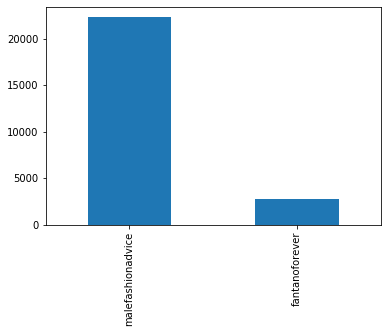

In [9]:
# Here is the spread
y_test.value_counts().plot.bar()

## Let's try to see what we can improve about our model

In [11]:
from sklearn.model_selection import GridSearchCV
def run_grid_search(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        StandardScaler(with_mean=False),
        model
    )
    grid_search = GridSearchCV(pipeline,
                              param_grid={
                                  "kneighborsclassifier__n_neighbors": range(5,26)
                              },
                              scoring='f1_micro', #I use f1 because I want to see how I can improve for all the classes
                              cv=4, n_jobs=8)

    return grid_search.fit(X_train, y_train)

In [12]:
gs = run_grid_search(KNeighborsClassifier(n_jobs=-1), X_train, y_train)

In [13]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
  

We see from this GridSearch that k should be set to 25 for best results. Let's see how that does.

In [24]:
pipeline = machine_learn(KNeighborsClassifier(n_neighbors=25, n_jobs=-1), X_train, y_train)
ypred = pipeline.predict(X_test)

In [25]:
get_scores_binary(y_test, ypred, y_test.unique())

Accuracy: 0.8872
malefashionadvice:
	Precision for malefashionadvice: 0.9037926307481411
	Recall for malefashionadvice: 0.9773595076591348
	F1 Score for malefashionadvice: 0.9391375663659516
fantanoforever:
	Precision for fantanoforever: 0.4563106796116505
	Recall for fantanoforever: 0.15443592552026286
	F1 Score for fantanoforever: 0.23076923076923075


With k = 19, we get a slightly better accuracy of 88.7%. The precision for /r/malefashionadvice drops, but the recall is great. On the other hand the precision for /r/fantanoforever rises but the recall now drops to an abysmal 15.4%.

For now, we will use this as our baseline, but let's hope our other models do better.

# Random Forest
## How Does Random Forest Perform On Our Data?
### All Subreddits

In [24]:
# Reminder of what our code looks like
# Also, I removed scaling because it is unnecessary for Random Forest
def machine_learn(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        model
    )

    return pipeline.fit(X_train, y_train)

In [25]:
df_sample = df.sample(n=200000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier
pipeline = machine_learn(RandomForestClassifier(n_jobs=-1), X_train, y_train)
ypred = pipeline.predict(X_test)

In [28]:
get_scores(y_test, ypred, y_test.unique())

Accuracy: 0.48375
Kanye:
	Precision for Kanye: 0.3834355828220859
	Recall for Kanye: 0.0716743119266055
	F1 Score for Kanye: 0.12077294685990339
hiphopheads:
	Precision for hiphopheads: 0.47529191966370854
	Recall for hiphopheads: 0.33908697100966345
	F1 Score for hiphopheads: 0.3957992998833139
leagueoflegends:
	Precision for leagueoflegends: 0.48270725127833475
	Recall for leagueoflegends: 0.9124511644426404
	F1 Score for leagueoflegends: 0.6313932361382967
malefashionadvice:
	Precision for malefashionadvice: 0.5248508946322068
	Recall for malefashionadvice: 0.18169304886441845
	F1 Score for malefashionadvice: 0.2699386503067485
cscareerquestions:
	Precision for cscareerquestions: 0.5775542615140286
	Recall for cscareerquestions: 0.29534380075798594
	F1 Score for cscareerquestions: 0.3908293032419846
MechanicalKeyboards:
	Precision for MechanicalKeyboards: 0.47108345534407026
	Recall for MechanicalKeyboards: 0.22254885007781428
	F1 Score for MechanicalKeyboards: 0.3022900763358779
Gl

Wow! We did a lot better than our previous accuracy of 29.53% for classification of all 13 classes. While not amazing, 48.4% is a good start especially given that I set no parameters. Let's see how it does on binary, hypertune some parameters, and then come back and see how the new parameters do on the full classification.

### Binary Classification

In [29]:
two_subs = df[(df['subreddit'] == 'fantanoforever') | (df['subreddit'] == 'malefashionadvice')]
df_sample = two_subs.sample(n=100000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [30]:
pipeline = machine_learn(RandomForestClassifier(n_jobs=-1), X_train, y_train)
ypred = pipeline.predict(X_test)
get_scores_binary(y_test, ypred, y_test.unique())

Accuracy: 0.90468
malefashionadvice:
	Precision for malefashionadvice: 0.9140988949006664
	Recall for malefashionadvice: 0.9852739186237643
	F1 Score for malefashionadvice: 0.9483528391850888
fantanoforever:
	Precision for fantanoforever: 0.6931018301267011
	Recall for fantanoforever: 0.2642691000178923
	F1 Score for fantanoforever: 0.3826424870466321


Out of the box our accuracy is a lot better with Random Forest with no tuning than the slightly tuned KNN model. Our accuracy here is 90% while for our b|est KNN we got 87.7%. The precision, recall, and F1 score are also a fair bit better with our Random Forest classifier which indicates that it is improving our predictions quite a bit.


Now I am going to tune the hyperparamters quite a bit. This will take a very long time to run so I cut down the number of cross validations to 4 to save time as well as my sanity.

In [95]:
def run_grid_search(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        model
    )
    grid_search = GridSearchCV(pipeline,
                                param_grid={
                                    "randomforestclassifier__max_features": [None, 'sqrt', 'log2'],
                                    "randomforestclassifier__criterion": ['gini', 'entropy'],
                                    "randomforestclassifier__bootstrap": [True, False]
                                },
                                scoring='accuracy',
                                cv=4, n_jobs=-1)

    return grid_search.fit(X_train, y_train)

In [96]:
gs = run_grid_search(RandomForestClassifier(n_jobs=-1), X_train, y_train)

In [97]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
  

The best estimator from this GridSearch use sqrt(n_features) for each tree, entropy as its split metric, and bootstrap sampled the training data for each tree. I will now run another GridSearch exploring other parameters.

In [99]:
def run_grid_search(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        model
    )
    grid_search = GridSearchCV(pipeline,
                                param_grid={
                                    "randomforestclassifier__min_samples_split": range(2, 11, 2),
                                    "randomforestclassifier__min_samples_leaf": [1,2,4,8]
                                },
                                scoring='accuracy',
                                cv=4, n_jobs=-1)
    
    return grid_search.fit(X_train, y_train)


In [100]:
gs = run_grid_search(RandomForestClassifier(n_jobs=-1, max_features='sqrt',
                                            bootstrap=True,
                                            criterion='entropy'
                                           ),
                     X_train, y_train)
gs.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
  

Looks like the min_samples_leaf should be left at 2 (the default) but min_samples_split should be set to 4 instead of 1. These parameters are thresholds for deciding whether to create children nodes during the decision tree training process. They help with mitigating the overfitting of our data.

## Tuning the number of unigrams and bigrams

To tune the number of unigrams and bigrams, I took our RF model that we tuned and sampled 200 thousand comments from all subreddits. I then tested the combination of 100, 250, 500, and 1000 unigrams with 100, 250, and 500 bigrams.

In [62]:
# to speed this up I will only use a sample of 200 thousand 

df_sample = df.sample(n=200000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [63]:
tuned_rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt',
                                  bootstrap=True, criterion='entropy',
                                  min_samples_leaf=2, min_samples_split=4)

def run_grid_search(model, X_train, y_train, X_test, y_test, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        model
    )
    
    pipeline.fit(X_train, y_train)
    ypred = pipeline.predict(X_test)
    return accuracy_score(y_test, ypred), f1_score(y_test, ypred, average='micro')

unigram_list = [100, 250, 500, 1000]
bigram_list = [100, 250, 500]


results = pd.DataFrame(columns=['unigram', 'bigram', 'Accuracy', 'F1'])

for u in unigram_list:
    for b in bigram_list:
        row = {}
        row['unigram'] = u
        row['bigram'] = b
        row["Accuracy"], row["F1"] = run_grid_search(tuned_rf, X_train, y_train, X_test, y_test, u, b)
        results = results.append(row, ignore_index=True)

In [64]:
results.sort_values('Accuracy')

,unigram,bigram,Accuracy,F1
0,100.0,100.0,0.40966,0.40966
1,100.0,250.0,0.41244,0.41244
2,100.0,500.0,0.41580,0.41580
3,250.0,100.0,0.44980,0.44980
4,250.0,250.0,0.44988,0.44988
5,250.0,500.0,0.45104,0.45104
6,500.0,100.0,0.47842,0.47842
7,500.0,250.0,0.47896,0.47896
8,500.0,500.0,0.47970,0.47970
10,1000.0,250.0,0.50982,0.50982


Hm it appears that the micro-weighted F1 score is the same as accuracy. The best I can find about this on short notice is [here.](https://stackoverflow.com/questions/51815299/same-accuracy-and-f1-score-while-doing-multi-label-classification). I should have set the average to 'weighted', but this took forever to run and we can still use the results of accuracy to make our decision.

It appears that 1000 unigrams and 500 bigrams is what gets us both the best accuracy and F1 score. Let's put this all together and predit for a different number of classes.

# Best RF Model For 2 Classes
Let's revist a binary classification but with 2 random subreddits.

In [53]:
pd.Series(df['subreddit'].unique()).sample(2)

3            Android
1    GlobalOffensive
dtype: object

In [56]:
two_subs = df[(df['subreddit'] == 'Android') | (df['subreddit'] == 'GlobalOffensive')]
df_sample = two_subs.sample(n=200000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [57]:
def machine_learn(model, X_train, y_train, n_unigrams=500, n_bigrams=500):
    ct = make_column_transformer(
        (TfidfVectorizer(max_features=n_unigrams), 'body'),
        (TfidfVectorizer(max_features=n_bigrams, ngram_range=(2,2)), 'body'),
        remainder='passthrough'
    )

    pipeline = make_pipeline(
        ct,
        model
    )

    return pipeline.fit(X_train, y_train)



In [58]:
pipeline = machine_learn(tuned_rf, X_train, y_train, n_unigrams=1000, n_bigrams=100)
ypred = pipeline.predict(X_test)

In [60]:
get_scores_binary(y_test, ypred, labels=y_test.unique())

Accuracy: 0.847232
Android:
	Precision for Android: 0.9003893026404874
	Recall for Android: 0.672191567330778
	F1 Score for Android: 0.7697335101893162
GlobalOffensive:
	Precision for GlobalOffensive: 0.8261903698409863
	Recall for GlobalOffensive: 0.9544492891973477
	F1 Score for GlobalOffensive: 0.8857006045370205


Since this is a completely different set of data than what we tuned on. I am not surprised by the drop of accuracy given how this is a completely different dataset than what we tested the hyperparametrs on. However, it appears that it did a pretty decent job with the F1 scores meaning it is fairly balanced. The accuracy did drop to 84% but it did a good job balancing precision and recall between the two classes. 

## How About 5 Random Subreddits?

In [72]:
pd.Series(df['subreddit'].unique()).sample(5)

1       GlobalOffensive
10    cscareerquestions
11    frugalmalefashion
5               CalPoly
8                 Kanye
dtype: object

In [74]:
five_subs = df[(df['subreddit'] == 'GlobalOffensive') | (df['subreddit'] == 'cscareerquestions')
             | (df['subreddit'] == 'frugalmalefashion') | (df['subreddit'] == 'CalPoly') | (df['subreddit'] == 'Kanye')]
df_sample = five_subs.sample(n=500000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [75]:
pipeline = machine_learn(tuned_rf, X_train, y_train, n_unigrams=1000, n_bigrams=500)
ypred = pipeline.predict(X_test)

In [77]:
get_scores(y_test, ypred, y_test.unique())

Accuracy: 0.733608
GlobalOffensive:
	Precision for GlobalOffensive: 0.6988297279497442
	Recall for GlobalOffensive: 0.9697016562157298
	F1 Score for GlobalOffensive: 0.8122788112188717
frugalmalefashion:
	Precision for frugalmalefashion: 0.862278978388998
	Recall for frugalmalefashion: 0.3967278315104402
	F1 Score for frugalmalefashion: 0.5434284653005633
cscareerquestions:
	Precision for cscareerquestions: 0.8788718730510706
	Recall for cscareerquestions: 0.584577802359882
	F1 Score for cscareerquestions: 0.7021341379023999
Kanye:
	Precision for Kanye: 0.8338988051335006
	Recall for Kanye: 0.2788437823706408
	F1 Score for Kanye: 0.41793582729557893
CalPoly:
	Precision for CalPoly: 1.0
	Recall for CalPoly: 0.0059382422802850355
	F1 Score for CalPoly: 0.01180637544273908


For 5 subreddits we get a decent accuracy of 73%. Precision scores across the board are actually quite good, however recall scores are low for most. I'd say this right here is the best we could ask for using such an unbalanced dataset, and I'm really happy with the results for the more moderate classification of 5 classes as opposed to 13, and it shows how our tree still works well when we stray from binary classification.

## All 13 Subreddits

I will use the majority of my data for this, because this is the ultimate test of my models. Let's see how my more refined Random Forest does on all the subreddits when fed 3 million comments to train and 1 million comments to test.

In [66]:
df_sample = df.sample(n=4000000)
X_train, X_test, y_train, y_test = train_test_split(df_sample[['body']], df_sample['subreddit'], train_size=.75, random_state=42)

In [67]:
pipeline = machine_learn(tuned_rf, X_train, y_train, n_unigrams=1000, n_bigrams=500)
ypred = pipeline.predict(X_test)

In [70]:
get_scores(y_test, ypred, y_test.unique())

Accuracy: 0.545213
leagueoflegends:
	Precision for leagueoflegends: 0.504429780940166
	Recall for leagueoflegends: 0.9534603898185222
	F1 Score for leagueoflegends: 0.6597943044241712
malefashionadvice:
	Precision for malefashionadvice: 0.641080646242542
	Recall for malefashionadvice: 0.3196296667669374
	F1 Score for malefashionadvice: 0.42657685788205907
hiphopheads:
	Precision for hiphopheads: 0.5906851243547631
	Recall for hiphopheads: 0.40199600798403196
	F1 Score for hiphopheads: 0.478407525298114
ProgrammerHumor:
	Precision for ProgrammerHumor: 0.5880821790462025
	Recall for ProgrammerHumor: 0.12597578461048273
	F1 Score for ProgrammerHumor: 0.20750168107194988
Android:
	Precision for Android: 0.7921448311396319
	Recall for Android: 0.45882225266899085
	F1 Score for Android: 0.5810763217798394
GlobalOffensive:
	Precision for GlobalOffensive: 0.7788479521226856
	Recall for GlobalOffensive: 0.1372237278920531
	F1 Score for GlobalOffensive: 0.23333636828429555
indieheads:
	Precision

After runnning the code for 6+ hours, we finally get our results. Our accuracy at 54.5% isn't amazing, but I am actually quite happy with it. Our recall, precision, and F1 scores have something to be desired for many of the classes. /r/leagueoflegends, our most represented class, has the highest F1 score of 66%. Not bad, but not great. Our lowest F1 score belongs to /r/fantanoforever, which is understandable given how underrepresented the class is and how it is similar to other music subreddits.

Some other interesting metrics to note are that I suspect some of the classes are conflicting with each other such as all of the music subreddits which seem to share similar frequency of words.

# Final Thoughts
I wish I had more time to fully explore the parameters for binary vs full classification and try to make models specific to those use cases. I wish I had made more use of all my data but there was so much and everything took a very long time to run which was unfortunate.